In [ ]:
'''
The script reads slp raw data from CESM-LENS and output:
1) pre-process and concatenate 40 ensembles of slp in north Atlantic
2) conduct EOF analysis of slp

'''

In [ ]:
import netCDF4 as nc
import numpy as np
import xarray as xr
import pandas as pd
from eofs.xarray import Eof

import matplotlib
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy as cart
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering

In [2]:
# return monthly average and regional longitude, latitude
# extract and group each month data
# after calculate the anomaly, remove the outliers
def month_data_slp(anom, month):
    month_group = anom.groupby("time.month").groups # group into seasons, use groups to read each group
    month_index = month_group[month]
    month_anom = anom[month_index,:,:]
    #### THE THRESHOLD????
    #month_anom = xr.where((month_anom>5), 0, month_anom)
    return month_anom


# calculate normalized anomalies -- CESM
# climatology based on 1976 to 2005 
def nor_anom(dataset):
    ds_clm = dataset.sel(time=slice("1976", "2005")).load()
    #lons_xr = dataset['lon'] # from -12W to 36E
    #lats_xr = dataset['lat'] # from 35N to 73N
    rr_clm = ds_clm

    gb_clm = rr_clm.groupby("time.month") # gb_clm: grouped data into 12 month for climatology
    gb = dataset.groupby("time.month")
    prcp_anom = ((gb - gb_clm.mean(dim="time")).groupby("time.month"))/gb_clm.std(dim="time") # normalized
    # important to add two times groupby
    # gb.mean: only 12 month -- average daily prcp at each month
    # prcp_anom -- each month one anomaly
    return prcp_anom

In [3]:
def data_load_cesm_slp(fn, start, end): # 'TP' 'NA' 'MD'
    ds_xr = xr.open_dataset(fn, chunks={"time": 10})
    ds_xr = ds_xr.sel(time=slice(start, end)).load()
    # convert 0-360 to -180-180
    #ds_xr = ds_xr.assign_coords(lon=(((ds_xr.lon + 180) % 360) - 180))
    # How to extract the desired region? -- by calculation
    reg_lon_xr = ds_xr['lon'] # from -40.375W to 75.375E
    reg_lat_xr = ds_xr['lat'] # from 25.375N to 75.375N
    temp_xr = ds_xr['PSL']
    # lat: -20 to 90; lon: -90W to 90E
    #xr1 = temp_xr[:,75:,:73].combine_first(temp_xr[:,75:,216:])
    xr1 = xr.concat([temp_xr[:,75:,216:], temp_xr[:,75:,:73]], dim="lon")
    # prec_xr = prec_xr1*1000*86400 # from m/s to mm/day
    # time, lat, lon
    return xr1, reg_lat_xr, reg_lon_xr

In [5]:
import os
path = r'C:/Users/yzh086/OneDrive - University of Bergen/PhD_lit/PhD_lit/task1/Data/CESM1/slp'
filelist = os.listdir(path)

pathlist = []
for i in range(len(filelist)):
    temp = path + '/' + filelist[i]
    pathlist.append(temp)
    
fn1 = pathlist[0]
# take the right time
temp_xr = xr.open_dataset(fn1, chunks={"time": 10})
### only ensemble 1 have 192001 ###
temp_xr = temp_xr.sel(time=slice('192001', '200512')).load() # be aware of the time here!!!

In [5]:
# preprocess SST -- all data together
def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

## change parameter for different region ##
#region = 'TP'

fn1 = pathlist[0]
# take the right time
temp_xr = xr.open_dataset(fn1, chunks={"time": 10})
### only ensemble 1 have 192001 ###
temp_xr = temp_xr.sel(time=slice('192001', '200512')).load() # be aware of the time here!!!

slp_xr, reg_lat_xr, reg_lon_xr = data_load_cesm_slp(fn1, '192002', '200601')

# calculate anomaly
slp_anom = nor_anom(slp_xr)

# detrend the time series at each grid point
slp_danom = detrend_dim(slp_anom, 'time', deg=1)

# extract and group each season data
#anom_ensemble = sst_anom
anom_original = slp_danom

data = np.squeeze(slp_danom.values) # remove dimension = 1
time = temp_xr.time
lat = slp_danom.lat
lon = slp_danom.lon
anom_ensemble = xr.DataArray(data, 
                    coords=[time,lat,lon],  # format for multiple dimensions
                    dims=['time', 'lat', 'lon'])

In [6]:
##### ensemble #####
for i in range(1,len(filelist)):

    fn1 = pathlist[i]
    slp_xr, reg_lat_xr, reg_lon_xr = data_load_cesm_slp(fn1, '192002', '200601')

    # total precipitation -- prect mm/day
    #prect_xr = precl_xr + precc_xr

    # calculate anomaly
    slp_anom = nor_anom(slp_xr)

    # detrend the time series at each grid point
    slp_danom = detrend_dim(slp_anom, 'time', deg=1)
    
    #if np.array_equal(anom_original.lat, slp_danom.lat) == False: # check if two array is exactly the same
    data = slp_danom.values # remove dimension = 1
    time = temp_xr.time
    lat = anom_original.lat
    lon = anom_original.lon
    anom_gb_temp = xr.DataArray(data, 
                        coords=[time, lat,lon], 
                        dims=['time', 'lat', 'lon'])

    anom_ensemble = xr.concat([anom_ensemble,anom_gb_temp], dim='time')


In [9]:
### save and load as netcdf ###
anom_ensemble.to_netcdf(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\slp_na.nc')

In [5]:
### save and load as netcdf ###
ensemble = xr.open_dataset(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\ensemble_data\slp\slp_na.nc')

ensemble = ensemble.__xarray_dataarray_variable__

In [7]:
time = ensemble.time
lat = ensemble.lat
lon = ensemble.lon

ensemble_new = xr.DataArray(ensemble.values, 
                            coords=[time, lat,lon], 
                            dims=['time', 'lat', 'lon'])

In [ ]:
##### preprocessing wrong data ####
# ensemble[33243] = ensemble[33231]

In [10]:
### For winter ###
sst_raw = ensemble
# find SEASONAL data
sst_all = sst_raw[sst_raw.time.dt.month.isin([12,1,2])] # select data of 12,1,2 month
# take the rolling series from 1921 to 2005
sst_rolling = sst_all[2:-1]
sst_mean1 = sst_rolling.rolling(time = 3).mean()
# mean value at each step 3
sst2 = sst_mean1[sst_mean1.time.dt.month == 2]
# mean at 1920
sst1 = sst_all[:2].mean(dim='time')
# reshape time to (1,)
time = sst_all[1].time.values.reshape(1,)
lat = sst_all[1].lat
lon = sst_all[1].lon
#tlat = sst_all[1].TLAT
#tlong = sst_all[1].TLONG
sst1 = xr.DataArray(sst1.values.reshape(1,sst_all.shape[1],sst_all.shape[2]),coords=[time,lat,lon],dims=('time', 'lat', 'lon'))

# concat two array
sst_series = xr.concat([sst1, sst2], dim="time")

In [14]:
### EOF ###
from eofs.xarray import Eof
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects

from scipy import stats

# weighted by latitude
meantlat = sst_series.lat
wgts   = np.cos(np.deg2rad(meantlat))
#wgts   = np.array(wgts).reshape(len(wgts), 1)
wgts   = np.array(wgts).reshape(117, 1) ## depends on the shape of region

solver = Eof(sst_series, weights=wgts)

eof_en = solver.eofs(neofs=10)
pc_en  = solver.pcs(npcs=10, pcscaling=0)
varfrac_en = solver.varianceFraction()
lambdas_en = solver.eigenvalues()

eof_en.to_netcdf(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\eof_slp\slp_eof_djf.nc')
pc_en.to_netcdf(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\eof_slp\slp_pc_djf.nc')
varfrac_en.to_netcdf(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\eof_slp\slp_var_djf.nc')
lambdas_en.to_netcdf(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\eof_slp\slp_lam_djf.nc')

In [15]:
### For MAM ###
sst_raw = ensemble
# find SEASONAL data
sst_all = sst_raw[sst_raw.time.dt.month.isin([3,4,5])] # select data of each season
# take the rolling series from 1921 to 2005
sst_rolling = sst_all
sst_mean1 = sst_rolling.rolling(time = 3).mean()
# mean value at each step 3
sst2 = sst_mean1[sst_mean1.time.dt.month == 5]

# concat two array
sst_series = sst2

In [16]:
### EOF ###
from eofs.xarray import Eof
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects

from scipy import stats

# weighted by latitude
meantlat = meantlat = sst_series.lat
wgts   = np.cos(np.deg2rad(meantlat))
#wgts   = np.array(wgts).reshape(len(wgts), 1)
wgts   = np.array(wgts).reshape(117, 1) ## depends on the shape of region

solver = Eof(sst_series, weights=wgts)

eof_en = solver.eofs(neofs=10)
pc_en  = solver.pcs(npcs=10, pcscaling=0)
varfrac_en = solver.varianceFraction()
lambdas_en = solver.eigenvalues()

eof_en.to_netcdf(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\eof_slp\slp_eof_mam.nc')
pc_en.to_netcdf(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\eof_slp\slp_pc_mam.nc')
varfrac_en.to_netcdf(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\eof_slp\slp_var_mam.nc')
lambdas_en.to_netcdf(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\eof_slp\slp_lam_mam.nc')

In [17]:
### For JJA ###
sst_raw = ensemble
# find SEASONAL data
sst_all = sst_raw[sst_raw.time.dt.month.isin([6,7,8])] # select data of each season
# take the rolling series from 1921 to 2005
sst_rolling = sst_all
sst_mean1 = sst_rolling.rolling(time = 3).mean()
# mean value at each step 3
sst2 = sst_mean1[sst_mean1.time.dt.month == 8]

# concat two array
sst_series = sst2

In [18]:
### EOF ###
from eofs.xarray import Eof
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects

from scipy import stats

# weighted by latitude
meantlat = meantlat = sst_series.lat
wgts   = np.cos(np.deg2rad(meantlat))
#wgts   = np.array(wgts).reshape(len(wgts), 1)
wgts   = np.array(wgts).reshape(117, 1) ## depends on the shape of region

solver = Eof(sst_series, weights=wgts)

eof_en = solver.eofs(neofs=10)
pc_en  = solver.pcs(npcs=10, pcscaling=0)
varfrac_en = solver.varianceFraction()
lambdas_en = solver.eigenvalues()

eof_en.to_netcdf(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\eof_slp\slp_eof_jja.nc')
pc_en.to_netcdf(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\eof_slp\slp_pc_jja.nc')
varfrac_en.to_netcdf(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\eof_slp\slp_var_jja.nc')
lambdas_en.to_netcdf(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\eof_slp\slp_lam_jja.nc')

In [9]:
### For SON ###
sst_raw = ensemble
# find SEASONAL data
sst_all = sst_raw[sst_raw.time.dt.month.isin([9,10,11])] # select data of each season
# take the rolling series from 1921 to 2005
sst_rolling = sst_all
sst_mean1 = sst_rolling.rolling(time = 3).mean()
# mean value at each step 3
sst2 = sst_mean1[sst_mean1.time.dt.month == 11]

# concat two array
sst_series = sst2

In [22]:
### EOF ###
from eofs.xarray import Eof
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects

from scipy import stats

# weighted by latitude
meantlat = meantlat = sst_series.lat
wgts   = np.cos(np.deg2rad(meantlat))
#wgts   = np.array(wgts).reshape(len(wgts), 1)
wgts   = np.array(wgts).reshape(117, 1) ## depends on the shape of region

solver = Eof(sst_series, weights=wgts)

eof_en = solver.eofs(neofs=10)
pc_en  = solver.pcs(npcs=10, pcscaling=0)
varfrac_en = solver.varianceFraction()
lambdas_en = solver.eigenvalues()

#eof_en.to_netcdf(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\eof_slp\slp_eof_son.nc')
#pc_en.to_netcdf(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\eof_slp\slp_pc_son.nc')
#varfrac_en.to_netcdf(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\eof_slp\slp_var_son.nc')
#lambdas_en.to_netcdf(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\eof_slp\slp_lam_son.nc')

In [14]:
eof_en = xr.open_dataset(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\eof_slp\slp_eof_son.nc')
varfrac_en = xr.open_dataset(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\eof_slp\slp_var_son.nc')

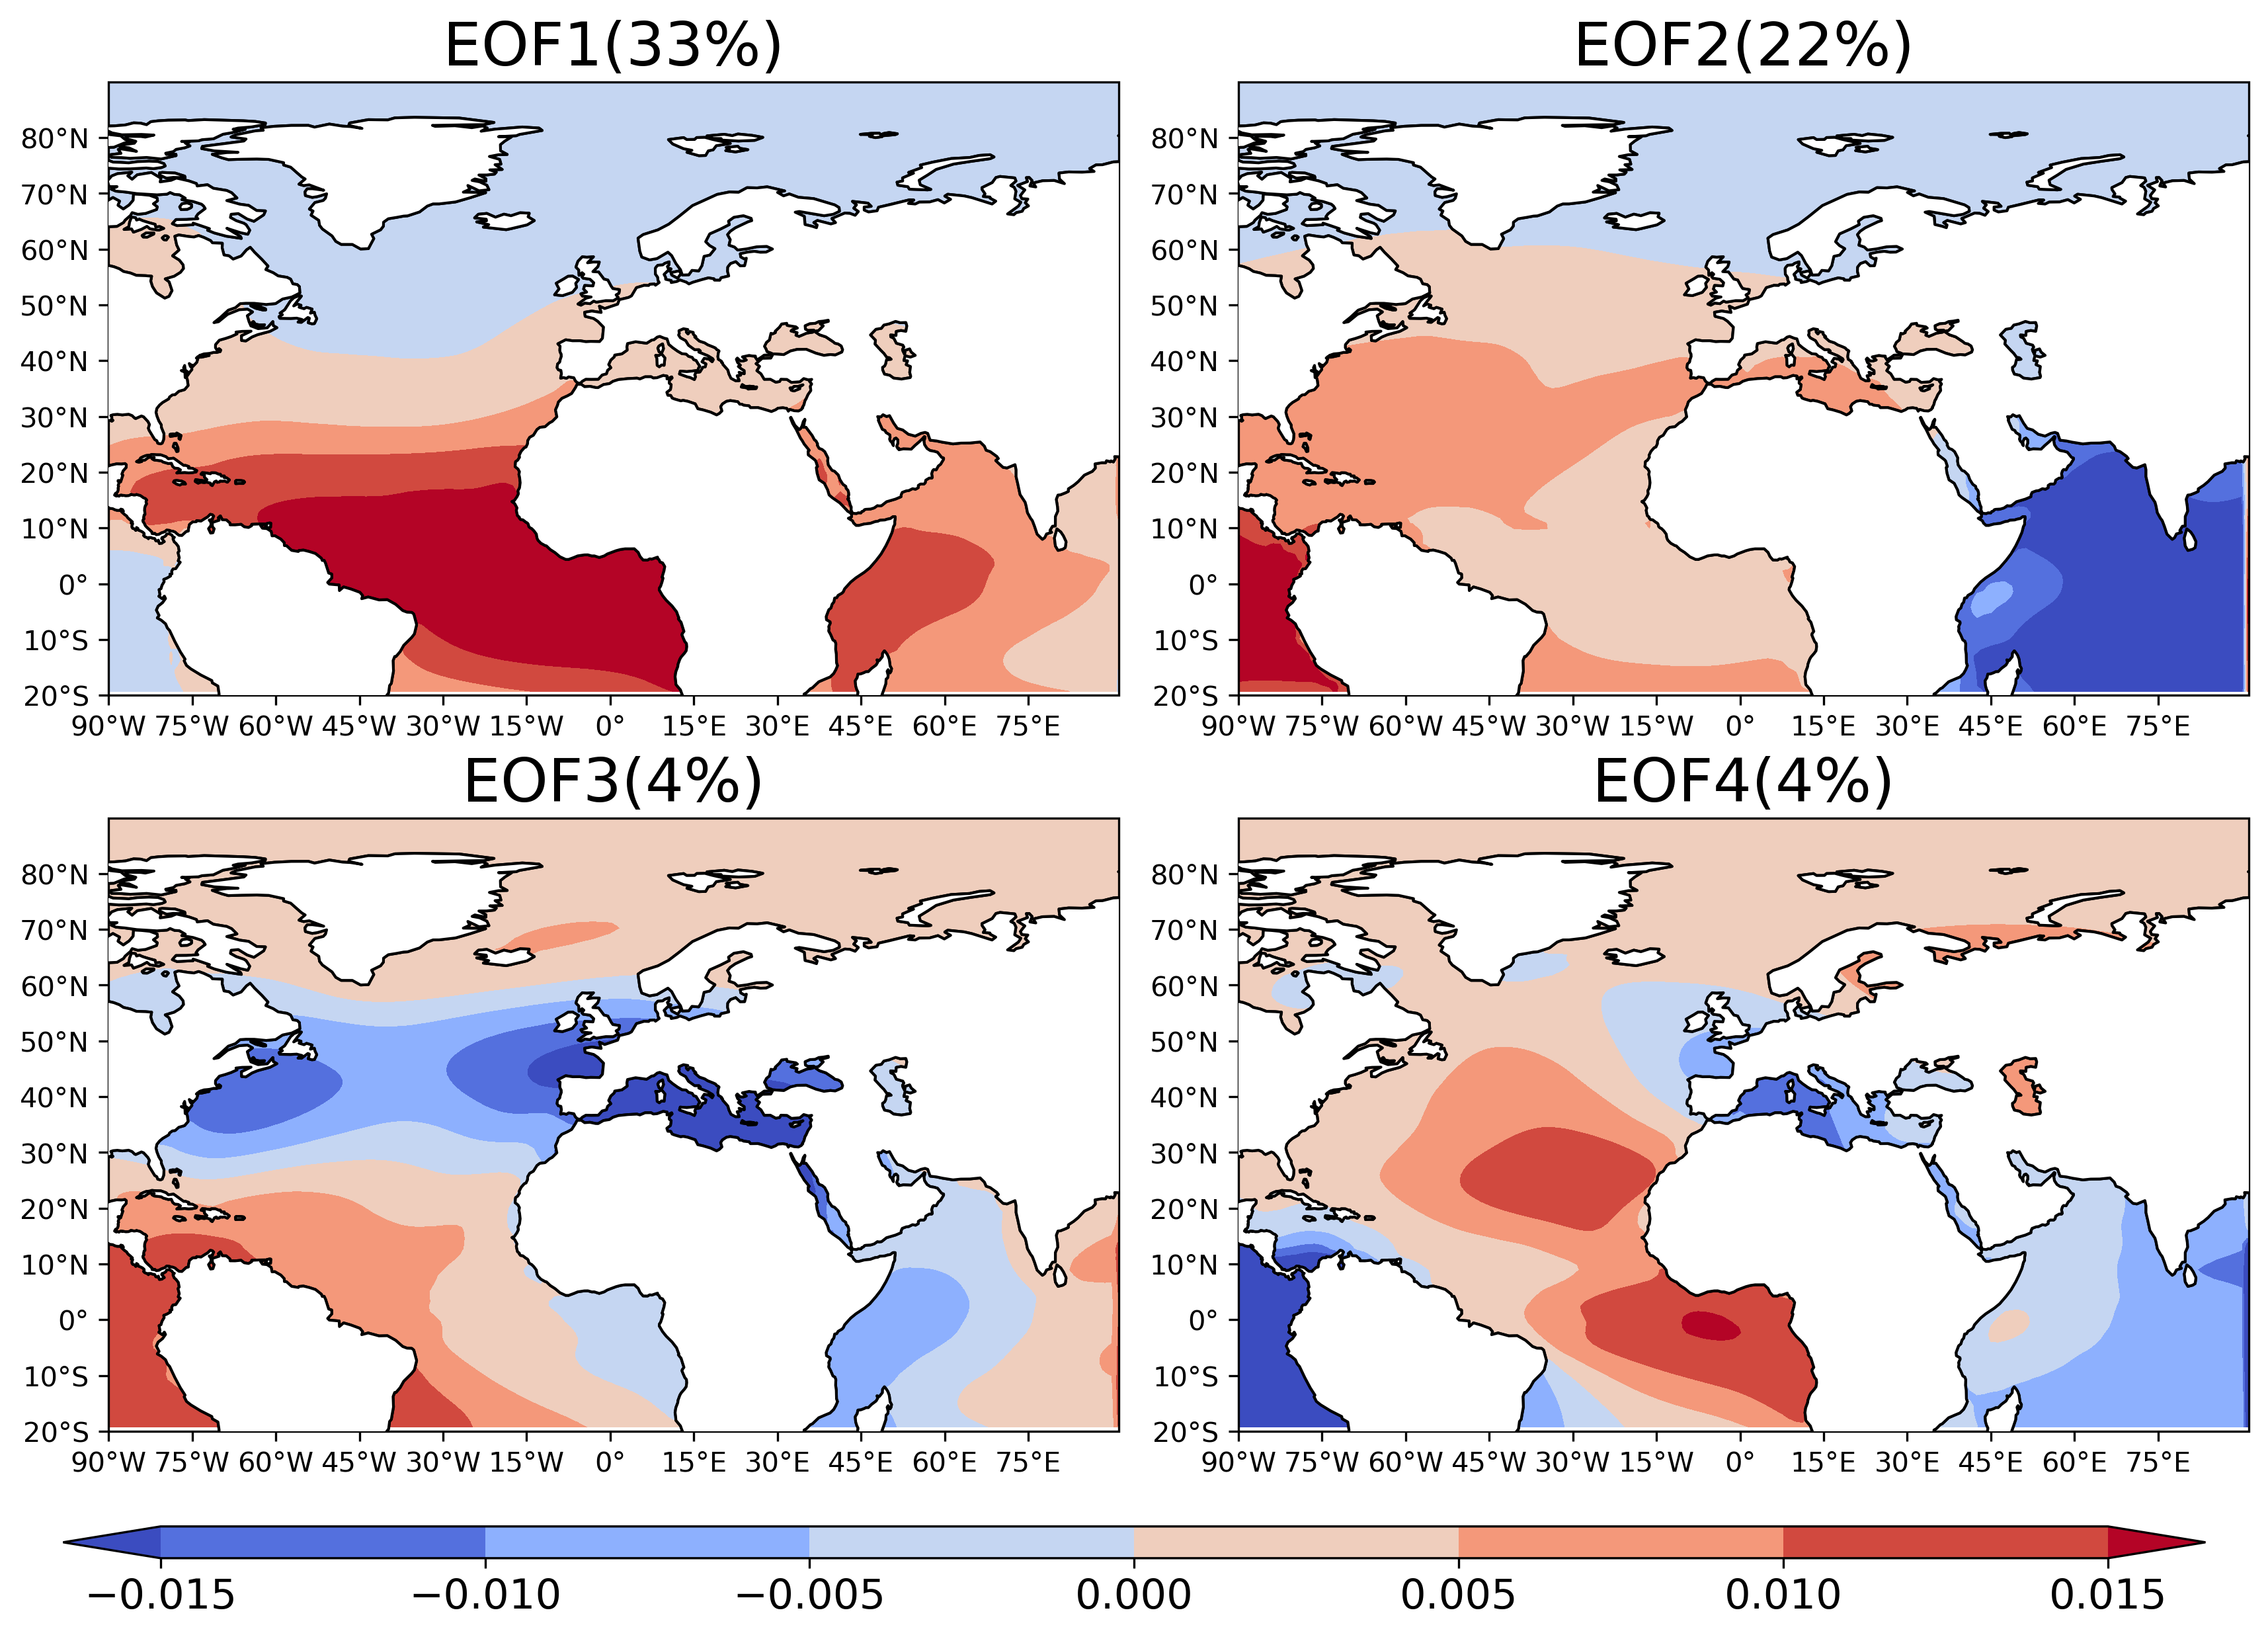

In [35]:
##### finally plot #####

fig, axs = plt.subplots(2,2, figsize=(12,8), subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=0)),dpi =300)

fig = plt.gcf()

#title1 = '%s_cluster' % (season)

for ax, i in zip(axs.ravel(), range(4)):

    title2 = 'EOF%s(%s%%)' % (i+1, int(varfrac_en[i]*100))
    # tim
    data = eof_en[i]
    # Add cyclic point to data
    #data=mean_anom_djf_cluster1
    data, lons = add_cyclic_point(data, coord=new_long)
    lat = new_lat
    # Make a filled contour plot
    # Add coastlines
    ax.coastlines()

    # mask the LAND part with white color
    ax.add_feature(cart.feature.LAND, facecolor = 'white', zorder=200, edgecolor='k')

    cs=ax.contourf(lons, new_lat, data,
                transform = ccrs.PlateCarree(),cmap='coolwarm',levels = np.linspace(-0.015,0.015,7),
                   extend='both') # (lat, lon)

    # Define the xticks for longitude

    ax.set_xticks(np.arange(-90,90,15), crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)

    # Define the yticks for latitude
    #plt.title(title2, fontsize = 18)
    ax.set_title(title2, fontsize = 22)

    ax.set_yticks(np.arange(-20,90,10), crs=ccrs.PlateCarree())
    lat_formatter = cticker.LatitudeFormatter()
    ax.yaxis.set_major_formatter(lat_formatter)

fig.tight_layout()
fig.subplots_adjust(bottom = 0.1, top = 0.95, hspace =0.2, wspace=.025)    

# Add colorbar
bar_cax = plt.axes([0.05, 0.02, 0.9,0.02]) # left&right, bottom, size, size
#plt.colorbar(cax=cax)
#cbar = plt.colorbar(cs,cax = bar_cax, orientation = 'horizontal', fraction = 0.05)
cbar = plt.colorbar(cs,cax = bar_cax, orientation = 'horizontal', fraction = 0.05)
cbar.ax.tick_params(labelsize = 15)
    
    
fig.savefig(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\result\eof\slp\eof_slp_son.png'
           ,bbox_inches='tight')

In [15]:
### EOF for monthly PC ###
from eofs.xarray import Eof
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects

from scipy import stats

# weighted by latitude
#meantlat = np.mean(ensemble.lat.values, axis = 1)
wgts   = np.cos(np.deg2rad(ensemble_new.lat))
#wgts   = np.array(wgts).reshape(len(wgts), 1)
wgts   = np.array(wgts).reshape(117, 1) ## depends on the shape of region

solver = Eof(ensemble_new, weights=wgts)

In [16]:
eof_en = solver.eofs(neofs=10)
pc_en  = solver.pcs(npcs=10, pcscaling=0)
varfrac_en = solver.varianceFraction()
lambdas_en = solver.eigenvalues()

In [17]:
eof_en.to_netcdf(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\slp_eof_na.nc')
pc_en.to_netcdf(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\slp_pc_na.nc')
varfrac_en.to_netcdf(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\slp_var_na.nc')
lambdas_en.to_netcdf(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\slp_lam_na.nc')

In [31]:
### re-apply for new coordinate since it is not equally placed ###
### this should be changed by different region ###
new_lat = np.linspace(-19.3,90,117) # -20 to 20
new_long = np.linspace(-90,90,145) # 110 E to 75 W


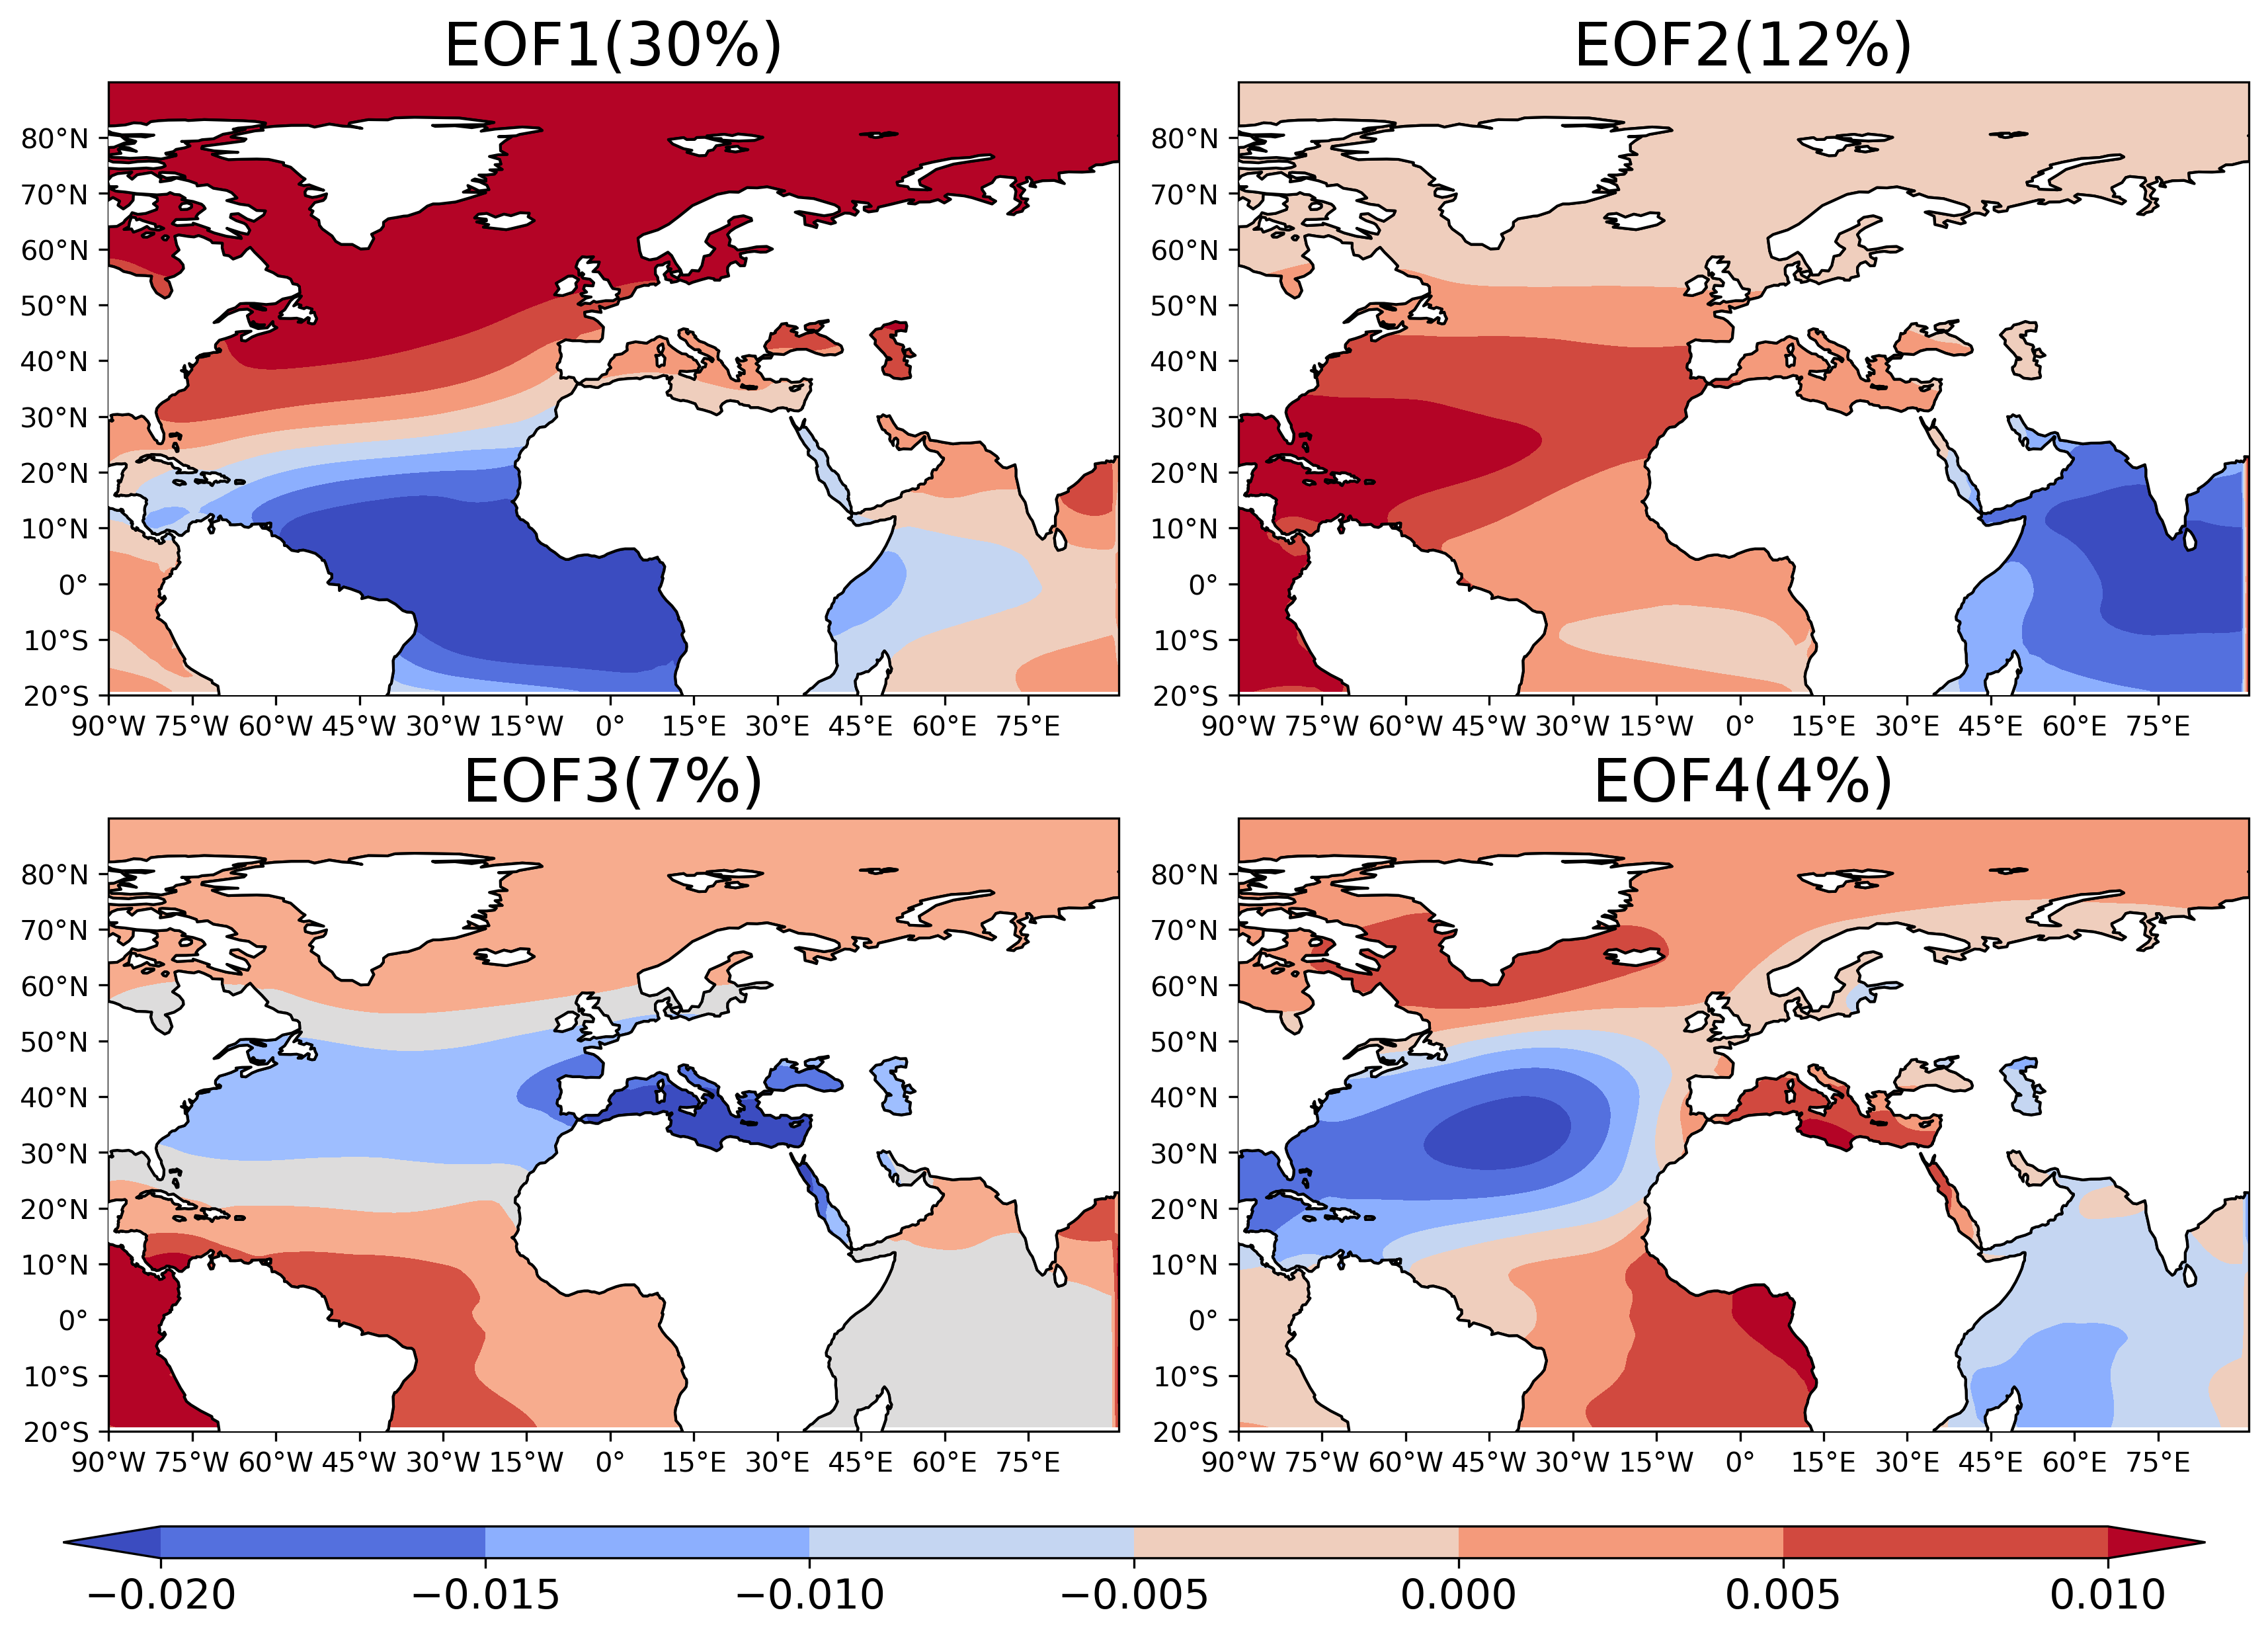

In [35]:
##### finally plot #####

#fig, ax = plt.subplots(figsize=(12, 9), subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)),dpi =300)
# if on the west sphere, change the central longitude

fig, axs = plt.subplots(2,2, figsize=(12,8), subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=0)),dpi =300)

fig = plt.gcf()

#title1 = '%s_cluster' % (season)

for ax, i in zip(axs.ravel(), range(4)):

    title2 = 'EOF%s(%s%%)' % (i+1, int(varfrac_en[i]*100))
    # tim
    data = eof_en[i]
    # Add cyclic point to data
    #data=mean_anom_djf_cluster1
    data, lons = add_cyclic_point(data, coord=new_long)
    lat = new_lat
    # Make a filled contour plot
    # Add coastlines
    ax.coastlines()

    # mask the LAND part with white color
    ax.add_feature(cart.feature.LAND, facecolor = 'white', zorder=200, edgecolor='k')

    cs=ax.contourf(lons, new_lat, data,
                transform = ccrs.PlateCarree(),cmap='coolwarm',#levels = np.linspace(-0.01,0.0,7),
                   extend='both') # (lat, lon)

    # Define the xticks for longitude

    ax.set_xticks(np.arange(-90,90,15), crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)

    # Define the yticks for latitude
    #plt.title(title2, fontsize = 18)
    ax.set_title(title2, fontsize = 22)

    ax.set_yticks(np.arange(-20,90,10), crs=ccrs.PlateCarree())
    lat_formatter = cticker.LatitudeFormatter()
    ax.yaxis.set_major_formatter(lat_formatter)

fig.tight_layout()
fig.subplots_adjust(bottom = 0.1, top = 0.95, hspace =0.2, wspace=.025)    

# Add colorbar
bar_cax = plt.axes([0.05, 0.02, 0.9,0.02]) # left&right, bottom, size, size
#plt.colorbar(cax=cax)
#cbar = plt.colorbar(cs,cax = bar_cax, orientation = 'horizontal', fraction = 0.05)
cbar = plt.colorbar(cs,cax = bar_cax, orientation = 'horizontal', fraction = 0.05)
cbar.ax.tick_params(labelsize = 15)
    
    
fig.savefig(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\result\eof\slp\eof_slp_test.png')